# Project 2 - Reinforcement Learning - MO436

**Group:** 
* Arthur Guazzelli (234984)
* Elian Laura (265685)
* Iury Cleveston (230216)
* Maria Tejada (197488)

## 1) Environment Description

In this project, we used the FrozenLake $8\times8$ environment from OpenAi Gym. This environment is represented as a grid with $8\times8$ tiles, where the goal is to cross the entire board without falling into ice holes. Frozen Lake is an episodic environment, where the initial state (S) is in the top-left position, and the terminal states are either the ice holes (H) or the final goal in the bottom-right tile (G). The ice holes are spread across the board, and the agent should find a path to the goal through frozen tiles (F); the reward of value of $1$ is only given at this point.

<br>
<div>
<center><img src="frozenLake.png" width="180"/></center>
<center>Figure 1 - Frozen Lake Grid.</center>
</div>


The current state is represented as a single number corresponding to the tile where the agent has entered, ranging from $0$ to $63$; therefore, this environment is discrete and partial observable. The possible actions are moving north, east, south, and west. Frozen Lake is presented in a deterministic and stochastic way; the difference is in the slippery ice, where the agent might slip and move to one of the four directions.

The ice holes are close to feasible paths to the goal; also, the reward is delayed until the end. These characteristics make Frozen Lake a challenging environment, especially in the stochastic version, where the dynamics are unpredictable.

Codes are available at https://github.com/thurbridi/mo436-project-1

Video are available at https://www.youtube.com/watch?v=S3_mXpYOIWU

In [1]:
import sys
sys.path.insert(0, '../src')

## 2) Off-policy methods

### 2.1) DQN (Elian)

### 2.2) SAC (Maria)


Soft Actor-Critic (SAC) is an algorithm that optimizes a stochastic policy in an off-policy way. 
A central feature of SAC is entropy regularization. The policy is to train to maximize a trade-off between expected return and entropy, a measure of randomness in the policy. This closely connects to the exploration-exploitation trade-off: increasing entropy results in more exploration, which can accelerate learning later on. It can also prevent the policy from prematurely converging to a bad local optimum. 


**Entropy-Regularized RL**

Let $x$ be a random variable with probability mass or density functions $P$. The entropy $H$ of $x$ is computed from its distribution $P$ according to:

<br><center>
  $$H(P) = \underset{x \sim P}{\mathbb{E}}[-\log P(x)]$$
<center>

In entropy-regularized reinforcement learning, the agent gets a bonus reward at each time step proportional to the entropy of the policy at that timestep. This changes the RL problems to:

<br><center>
  $$\pi^{*} = \underset{\pi}{\text{arg max}} \; \underset{\tau \sim \pi}{\mathbb{E}} \left [\displaystyle \sum^{\infty}_{t=0} \gamma^t \Biggl( R(s_t, a_t, s_{t+1}) + \alpha H(\pi(\centerdot | s_t)) \Biggl) \right]$$
<center>

where $\alpha > 0$ is the trade-off coefficient. We can noew define the slightly-diffent value functions in this setting. $V^{\pi}$ is changed to include the entropy bonuses from every timestep:
    
<br><center>
  $$V^{\pi}(s) = \underset{\tau \sim \pi}{\mathbb{E}} \left[\displaystyle \sum^{\infty}_{t=0} \gamma^t \Biggl( R(s_t, a_t, s_{t+1}) + \alpha H(\pi(\centerdot | s_t)) \Biggl) \Biggl| s_0 = s \right]$$
<center> 
    
$Q^{pi}$ is changed to include the entropy bonuses from every timestep except the first:

<br><center>
  $$Q^{\pi}(s,a) = \underset{\tau \sim \pi}{\mathbb{E}} \left[\displaystyle \sum^{\infty}_{t=0} \gamma^t R(s_t, a_t, s_{t+1}) + \alpha^t \sum^{\infty}_{t=0} H(\pi(\centerdot | s_t)) \Biggl| s_0 = s, a_0 = a \right]$$
<center>    

With the definitions, $V^{\pi}$ and $Q^{\pi}$ are connected by:
    
<br><center>
  $$V^{\pi}(s) = \underset{a \sim \pi}{\mathbb{E}}[Q^{\pi}(s,a)] + \alpha H(\pi(\centerdot|s))$$
<center>
    
and the Bellman equation for $Q^{\pi}$ is

<br><center>
  $$Q^{\pi}(s,a) = \underset{s' \sim P}{\mathbb{E}}[R(s,a,s') + \gamma V^{\pi}(s')]$$
<center>

SAC concurrently learns a policy $\pi_\theta$ and two Q-functions $Q_{\phi_1}$, $Q_{\phi_2}$. There are two variants of SAC that are currently standard: one that uses a fixed entropy regularizaiton coefficient $\alpha$, and another that enforces an entropy constraint by varying $\alpha$ over the course of training. 

**$Q$-loss**

In the final form of the $Q$-loss, let's take a moment to discuss how the contribution from entropy regularization comes in. It will start by taking its recursive Bellman equation ofr the entropy-regularized $Q^{\pi}$ from earlier, and rewriting it a little bit by using the definition of entropy:


<br><center>
  $$Q^{\pi}(s,a) = \underset{\substack{s'\sim P \\ a' \sim \pi}}{\mathbb{E}} \left[R(s, a, s') + \gamma \Bigl( Q^{\pi}(s',a') + \alpha H(\pi(\centerdot | s')) \Bigl)  \right]$$
  $$Q^{\pi}(s,a) = \underset{\substack{s'\sim P \\ a' \sim \pi}}{\mathbb{E}} \left[R(s, a, s') + \gamma \Bigl( Q^{\pi}(s',a') - \alpha \, \text{log} \pi(\centerdot | s') \Bigl)  \right]$$
<center>    
    
The RHS is an expectation over next states (which come from the replay buffer) and next actions (which come from the current policy, and **not** the replay buffer). Since it's an expectation, we can approximate it with samples:

    
<br><center>
  $$Q^{\pi}(s,a) \approx r + \gamma \Bigl(Q^{\pi}(s', \tilde{a}') - \alpha \, \text{log}\pi(\tilde{a}'|s')\Bigl), \;\;\; \tilde{a}' \sim \pi(\centerdot | s')$$
<center>    
 

SAC sets up the MSBE loss for each $Q$-function using this kind of sample approximation for the target. THe only thing still undetermined here is which $Q$-function gets used to compute the sample backup; SAC uses the clipped double-$Q$ trick, and takes the minimum $Q$-value between the two $Q$ approximators. 

Putting it all together, the loss functions for the $Q$-networks in SAC are:

<br><center>
  $$L(\phi_i, D) = \underset{(s,a,r,s',d) \sim D}{\mathbb{E}} \left[\Bigl((Q_{\phi_i}(s, a) - y(r,s',d) \Bigl)^2  \right]$$
  $$y(r,s',d) = r + \gamma(1-d) \Bigl( \underset{j=1,2}{\text{min}} Q_{\phi{\text{targ},j}}(s',\tilde{a}') - \alpha \, \text{log} \pi_{\theta}(\tilde{a}'|s')  \Bigl), \;\;\; \tilde{a}' \sim \pi_{\theta}(\centerdot | s')$$  
<center> 
    
**Learning the Policy**
    
The policy should, in each state, act to maximize the expected future return plus expected future entropy. That is, it should maximize $V^{\pi}(s)$, which is expand out into:

<br><center>
  $$V^{\pi}(s) = \underset{a \sim \pi}{\mathbb{E}} [Q^{\pi}(s, a)] + \alpha H(\pi(\centerdot | s))$$
  $$V^{\pi}(s) = \underset{a \sim \pi}{\mathbb{E}} [Q^{\pi}(s,a) - \alpha \, \text{log}\pi(a|s))]$$  
<center> 
    

 

We use keras_gym to carry out the corresponding tests in the chosen environment. This implementation is based on an off-policy actor-critic deep RL algorithm based on the maximum entropy reinforcement learning framework. In this framework, the actor maximizes the expected reward while also maximizing the entropy. We used the linear function approximator.

#### 2.2.1) Deterministic Environment

In [2]:
from SAC import *

2021-12-04 01:00:11.084876: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-04 01:00:11.084913: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/marta2/miniconda3/envs/mo436/lib/python3.9/site-packages/keras_gym/base/patches.py:23: UserWarning: keras-gym has known issues with eager execution mode; eager execution has been disabled as a precaution. You may try and enable eager execution with: tf.compat.v1.enable_eager_execution()
  warnings.warn(


The first experiment consisted in applying the SAC in deterministic environment. Therefore, we used a grid search techniques to find the best solution given the parameters defined as:

* $\text{episode} \in [1000]$,
* $\text{target model sync period} \in [10]$,
* $\text{learning rate} \in [0.005]$,
* $\tau \in [1.0, 0.5]$,
* $\text{punishment} \in [-0.25, -0.1, -0.01]$.

This algorithm took a long time to search for parameters, so the parameters were chosen incrementally, to see which parameters were obtained results. Therefore, some parameters only show a single variable. Furthermore, it was tested with two 2 approximators: linear and MLP; however MLP did not have very good results, so the results are only shown with a linear approximator. 

In [ ]:
result = search_params(False, 6)

In [25]:
result

,model_sync_period,episodes,lr,tau,punishment,reward_train,reward,elapsed time (s)
0,10.0,1000.0,0.005,1.0,-0.25,2.2,0.0,123.896235
1,10.0,1000.0,0.005,0.5,-0.25,1.2,0.0,120.049838
2,10.0,1000.0,0.005,1.0,-0.10,24.9,100.0,170.929226
3,10.0,1000.0,0.005,0.5,-0.10,37.6,100.0,182.357239
4,10.0,1000.0,0.005,1.0,-0.01,60.3,100.0,649.997202
5,10.0,1000.0,0.005,0.5,-0.01,0.1,0.0,1901.403648


In [ ]:
env = gym.make('FrozenLake8x8-v0', is_slippery=False)
env = km.wrappers.TrainMonitor(env, tensorboard_dir=tbdir)

#km.enable_logging()
func, sac, pi, Reward = sac_train(env, 1000 ,10 , 0.005, 1.0, -0.1)

Text(0, 0.5, 'reward')

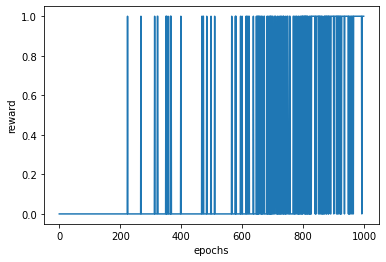

In [8]:
plt.plot(Reward)
plt.xlabel('epochs')
plt.ylabel('reward')

In [9]:
sac_test(env, sac, num_test=1, display=True)


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 0.256
 pi(L|s) = 0.001
 pi(S|s) = 0.239
 pi(R|s) = 0.759
 pi(N|s) = 0.001
 q1(s,L) = -0.005
 q1(s,S) = 0.241
 q1(s,R) = 0.257
 q1(s,N) = 0.265
 q2(s,L) = -0.005
 q2(s,S) = 0.241
 q2(s,R) = 0.257
 q2(s,N) = 0.265
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 0.317
 pi(L|s) = 0.001
 pi(S|s) = 0.130
 pi(R|s) = 0.867
 pi(N|s) = 0.001
 q1(s,L) = 0.031
 q1(s,S) = 0.330
 q1(s,R) = 0.244
 q1(s,N) = 0.243
 q2(s,L) = 0.031
 q2(s,S) = 0.330
 q2(s,R) = 0.244
 q2(s,N) = 0.243
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 0.256
 pi(L|s) = 0.002
 pi(S|s) = 0.223
 pi(R|s) = 0.773
 pi(N|s) = 0.002
 q1(s,L) = -0.010
 q1(s,S) = 0.271
 q1(s,R) = 0.256
 q1(s,N) = 0.267
 q2(s,L) = -0.010
 q2(s,S) = 0.271
 q2(s,R) = 0.256
 q2(s,N) = 0.267
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 0.283
 pi(L|s) 

INFO:TrainMonitor:ep: 1001, T: 10,630, G: 1, avg_G: 0.728, t: 14, dt: 72.063ms, loss: 0.00167, policy/entropy: 0.334, policy/loss: -0.00228, v_func/loss: 0.00205, q_func1/loss: 0.000454, q_func2/loss: 0.000454, value/loss: 0.000985


  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 0.456
 pi(L|s) = 0.003
 pi(S|s) = 0.918
 pi(R|s) = 0.077
 pi(N|s) = 0.003
 q1(s,L) = 0.290
 q1(s,S) = 0.458
 q1(s,R) = 0.341
 q1(s,N) = 0.324
 q2(s,L) = 0.290
 q2(s,S) = 0.458
 q2(s,R) = 0.341
 q2(s,N) = 0.324
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 0.508
 pi(L|s) = 0.001
 pi(S|s) = 0.977
 pi(R|s) = 0.021
 pi(N|s) = 0.001
 q1(s,L) = 0.250
 q1(s,S) = 0.518
 q1(s,R) = -0.011
 q1(s,N) = 0.240
 q2(s,L) = 0.250
 q2(s,S) = 0.518
 q2(s,R) = -0.011
 q2(s,N) = 0.240
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 0.567
 pi(L|s) = 0.001
 pi(S|s) = 0.025
 pi(R|s) = 0.974
 pi(N|s) = 0.001
 q1(s,L) = 0.106
 q1(s,S) = 0.276
 q1(s,R) = 0.572
 q1(s,N) = 0.133
 q2(s,L) = 0.106
 q2(s,S) = 0.276
 q2(s,R) = 0.572
 q2(s,N) = 0.133
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 0.635
 pi(L

1.0

#### 2.2.2) Stochastic Environment 

In [ ]:
result = search_params(True, 6)
result

In [14]:
env = gym.make('FrozenLake8x8-v0', is_slippery=True)
env = km.wrappers.TrainMonitor(env, tensorboard_dir=tbdir)

#km.enable_logging()
func, sac, pi, Reward = sac_train(env, 2000 ,10 , 0.1, 1.0, -0.01)

INFO:TrainMonitor:ep: 1, T: 174, G: 0, avg_G: 0, t: 173, dt: 61.184ms, loss: 0.722, policy/entropy: 0.648, policy/loss: 0.0094, v_func/loss: 0.178, q_func1/loss: 0.178, q_func2/loss: 0.178, value/loss: 0.178
INFO:TrainMonitor:ep: 2, T: 375, G: 0, avg_G: 0, t: 200, dt: 18.824ms, loss: 0.802, policy/entropy: 0.342, policy/loss: 0.0219, v_func/loss: 0.222, q_func1/loss: 0.181, q_func2/loss: 0.181, value/loss: 0.195
INFO:TrainMonitor:ep: 3, T: 405, G: 0, avg_G: 0, t: 29, dt: 17.130ms, loss: 0.938, policy/entropy: 0.306, policy/loss: 0.00186, v_func/loss: 0.229, q_func1/loss: 0.237, q_func2/loss: 0.237, value/loss: 0.234
INFO:TrainMonitor:ep: 4, T: 449, G: 0, avg_G: 0, t: 43, dt: 18.645ms, loss: 1.16, policy/entropy: 0.261, policy/loss: -0.02, v_func/loss: 0.282, q_func1/loss: 0.302, q_func2/loss: 0.302, value/loss: 0.295
INFO:TrainMonitor:ep: 5, T: 650, G: 0, avg_G: 0, t: 200, dt: 18.814ms, loss: 1.97, policy/entropy: 0.132, policy/loss: 0.116, v_func/loss: 0.522, q_func1/loss: 0.434, q_fu

INFO:TrainMonitor:ep: 40, T: 5,609, G: 0, avg_G: 0, t: 200, dt: 18.933ms, loss: 1.18, policy/entropy: 0.004, policy/loss: 0.0253, v_func/loss: 0.287, q_func1/loss: 0.288, q_func2/loss: 0.288, value/loss: 0.287
INFO:TrainMonitor:ep: 41, T: 5,646, G: 0, avg_G: 0, t: 36, dt: 17.975ms, loss: 0.972, policy/entropy: 0.00405, policy/loss: -0.0223, v_func/loss: 0.24, q_func1/loss: 0.253, q_func2/loss: 0.253, value/loss: 0.249
INFO:TrainMonitor:ep: 42, T: 5,847, G: 0, avg_G: 0, t: 200, dt: 19.161ms, loss: 0.477, policy/entropy: 0.00332, policy/loss: -0.0249, v_func/loss: 0.124, q_func1/loss: 0.126, q_func2/loss: 0.126, value/loss: 0.125
INFO:TrainMonitor:ep: 43, T: 6,048, G: 0, avg_G: 0, t: 200, dt: 18.999ms, loss: 1.01, policy/entropy: 0.00375, policy/loss: -0.0732, v_func/loss: 0.283, q_func1/loss: 0.265, q_func2/loss: 0.265, value/loss: 0.271
INFO:TrainMonitor:ep: 44, T: 6,249, G: 0, avg_G: 0, t: 200, dt: 18.709ms, loss: 0.788, policy/entropy: 0.00197, policy/loss: 0.0095, v_func/loss: 0.201

INFO:TrainMonitor:ep: 79, T: 11,538, G: 0, avg_G: 0, t: 16, dt: 16.947ms, loss: 0.232, policy/entropy: 0.000459, policy/loss: -0.00218, v_func/loss: 0.0746, q_func1/loss: 0.0504, q_func2/loss: 0.0504, value/loss: 0.0585
INFO:TrainMonitor:ep: 80, T: 11,739, G: 0, avg_G: 0, t: 200, dt: 18.847ms, loss: 0.482, policy/entropy: 0.000914, policy/loss: 0.0139, v_func/loss: 0.118, q_func1/loss: 0.116, q_func2/loss: 0.116, value/loss: 0.117
INFO:TrainMonitor:ep: 81, T: 11,852, G: 0, avg_G: 0, t: 112, dt: 18.995ms, loss: 0.588, policy/entropy: 0.000768, policy/loss: -0.00284, v_func/loss: 0.16, q_func1/loss: 0.142, q_func2/loss: 0.142, value/loss: 0.148
INFO:TrainMonitor:ep: 82, T: 12,053, G: 0, avg_G: 0, t: 200, dt: 18.947ms, loss: 0.963, policy/entropy: 0.00101, policy/loss: 0.0162, v_func/loss: 0.282, q_func1/loss: 0.214, q_func2/loss: 0.214, value/loss: 0.237
INFO:TrainMonitor:ep: 83, T: 12,205, G: 0, avg_G: 0, t: 151, dt: 19.129ms, loss: 1.43, policy/entropy: 0.00102, policy/loss: 0.052, v_f

INFO:TrainMonitor:ep: 118, T: 17,951, G: 0, avg_G: 0, t: 121, dt: 18.895ms, loss: 1.16, policy/entropy: 0.0167, policy/loss: -0.00248, v_func/loss: 0.3, q_func1/loss: 0.287, q_func2/loss: 0.287, value/loss: 0.291
INFO:TrainMonitor:ep: 119, T: 18,152, G: 0, avg_G: 0, t: 200, dt: 19.124ms, loss: 0.909, policy/entropy: 0.0119, policy/loss: -0.0329, v_func/loss: 0.234, q_func1/loss: 0.236, q_func2/loss: 0.236, value/loss: 0.235
INFO:TrainMonitor:ep: 120, T: 18,235, G: 0, avg_G: 0, t: 82, dt: 18.491ms, loss: 1.08, policy/entropy: 0.00966, policy/loss: -0.138, v_func/loss: 0.33, q_func1/loss: 0.292, q_func2/loss: 0.292, value/loss: 0.305
INFO:TrainMonitor:ep: 121, T: 18,436, G: 0, avg_G: 0, t: 200, dt: 18.864ms, loss: 2.09, policy/entropy: 0.0064, policy/loss: 0.0978, v_func/loss: 0.515, q_func1/loss: 0.491, q_func2/loss: 0.491, value/loss: 0.499
INFO:TrainMonitor:ep: 122, T: 18,527, G: 0, avg_G: 0, t: 90, dt: 19.144ms, loss: 1.28, policy/entropy: 0.00861, policy/loss: 0.00998, v_func/loss: 

INFO:TrainMonitor:ep: 157, T: 21,941, G: 0, avg_G: 0, t: 44, dt: 19.711ms, loss: 1.58, policy/entropy: 0.00558, policy/loss: 0.0251, v_func/loss: 0.359, q_func1/loss: 0.405, q_func2/loss: 0.405, value/loss: 0.39
INFO:TrainMonitor:ep: 158, T: 21,971, G: 0, avg_G: 0, t: 29, dt: 18.335ms, loss: 1.59, policy/entropy: 0.00474, policy/loss: -0.0289, v_func/loss: 0.404, q_func1/loss: 0.405, q_func2/loss: 0.405, value/loss: 0.405
INFO:TrainMonitor:ep: 159, T: 22,141, G: 0, avg_G: 0, t: 169, dt: 19.210ms, loss: 0.987, policy/entropy: 0.00224, policy/loss: -0.00683, v_func/loss: 0.273, q_func1/loss: 0.236, q_func2/loss: 0.236, value/loss: 0.248
INFO:TrainMonitor:ep: 160, T: 22,159, G: 0, avg_G: 0, t: 17, dt: 17.441ms, loss: 0.977, policy/entropy: 0.00332, policy/loss: 0.0291, v_func/loss: 0.258, q_func1/loss: 0.226, q_func2/loss: 0.226, value/loss: 0.237
INFO:TrainMonitor:ep: 161, T: 22,173, G: 0, avg_G: 0, t: 13, dt: 17.601ms, loss: 1.02, policy/entropy: 0.00457, policy/loss: -0.0264, v_func/lo

INFO:TrainMonitor:ep: 196, T: 23,647, G: 0, avg_G: 0, t: 42, dt: 18.193ms, loss: 0.87, policy/entropy: 0.00249, policy/loss: -0.00881, v_func/loss: 0.24, q_func1/loss: 0.209, q_func2/loss: 0.209, value/loss: 0.22
INFO:TrainMonitor:ep: 197, T: 23,657, G: 0, avg_G: 0, t: 9, dt: 15.741ms, loss: 0.832, policy/entropy: 0.00231, policy/loss: -0.0109, v_func/loss: 0.23, q_func1/loss: 0.201, q_func2/loss: 0.201, value/loss: 0.211
INFO:TrainMonitor:ep: 198, T: 23,667, G: 0, avg_G: 0, t: 9, dt: 14.866ms, loss: 0.784, policy/entropy: 0.00238, policy/loss: -0.0349, v_func/loss: 0.222, q_func1/loss: 0.196, q_func2/loss: 0.196, value/loss: 0.205
INFO:TrainMonitor:ep: 199, T: 23,679, G: 0, avg_G: 0, t: 11, dt: 15.844ms, loss: 0.761, policy/entropy: 0.00226, policy/loss: -0.0114, v_func/loss: 0.21, q_func1/loss: 0.185, q_func2/loss: 0.185, value/loss: 0.193
INFO:TrainMonitor:ep: 200, T: 23,702, G: 0, avg_G: 0, t: 22, dt: 17.374ms, loss: 0.722, policy/entropy: 0.00211, policy/loss: 0.0144, v_func/loss:

INFO:TrainMonitor:ep: 235, T: 24,792, G: 0, avg_G: 0, t: 67, dt: 19.180ms, loss: 1.04, policy/entropy: 0.0134, policy/loss: -0.0182, v_func/loss: 0.311, q_func1/loss: 0.242, q_func2/loss: 0.242, value/loss: 0.265
INFO:TrainMonitor:ep: 236, T: 24,815, G: 0, avg_G: 0, t: 22, dt: 18.445ms, loss: 1.18, policy/entropy: 0.012, policy/loss: -0.0599, v_func/loss: 0.332, q_func1/loss: 0.3, q_func2/loss: 0.3, value/loss: 0.31
INFO:TrainMonitor:ep: 237, T: 24,830, G: 0, avg_G: 0, t: 14, dt: 16.721ms, loss: 1.31, policy/entropy: 0.0111, policy/loss: -0.0828, v_func/loss: 0.387, q_func1/loss: 0.331, q_func2/loss: 0.331, value/loss: 0.349
INFO:TrainMonitor:ep: 238, T: 24,848, G: 0, avg_G: 0, t: 17, dt: 14.808ms, loss: 1.39, policy/entropy: 0.0096, policy/loss: 0.00475, v_func/loss: 0.388, q_func1/loss: 0.326, q_func2/loss: 0.326, value/loss: 0.347
INFO:TrainMonitor:ep: 239, T: 24,878, G: 0, avg_G: 0, t: 29, dt: 17.258ms, loss: 1.23, policy/entropy: 0.00832, policy/loss: -0.072, v_func/loss: 0.378, q

INFO:TrainMonitor:ep: 274, T: 25,866, G: 0, avg_G: 0, t: 22, dt: 18.525ms, loss: 1.31, policy/entropy: 0.0141, policy/loss: 0.00898, v_func/loss: 0.357, q_func1/loss: 0.311, q_func2/loss: 0.311, value/loss: 0.326
INFO:TrainMonitor:ep: 275, T: 25,923, G: 0, avg_G: 0, t: 56, dt: 18.933ms, loss: 3.16, policy/entropy: 0.0101, policy/loss: 0.0705, v_func/loss: 0.831, q_func1/loss: 0.743, q_func2/loss: 0.743, value/loss: 0.773
INFO:TrainMonitor:ep: 276, T: 25,934, G: 0, avg_G: 0, t: 10, dt: 16.593ms, loss: 3.2, policy/entropy: 0.0101, policy/loss: 0.089, v_func/loss: 0.901, q_func1/loss: 0.716, q_func2/loss: 0.716, value/loss: 0.778
INFO:TrainMonitor:ep: 277, T: 25,955, G: 0, avg_G: 0, t: 20, dt: 17.593ms, loss: 2.9, policy/entropy: 0.0101, policy/loss: -0.0126, v_func/loss: 0.846, q_func1/loss: 0.669, q_func2/loss: 0.669, value/loss: 0.728
INFO:TrainMonitor:ep: 278, T: 25,973, G: 0, avg_G: 0, t: 17, dt: 17.468ms, loss: 2.72, policy/entropy: 0.01, policy/loss: 0.042, v_func/loss: 0.766, q_fu

INFO:TrainMonitor:ep: 313, T: 27,079, G: 0, avg_G: 0, t: 39, dt: 18.056ms, loss: 1.7, policy/entropy: 0.0192, policy/loss: 0.0465, v_func/loss: 0.458, q_func1/loss: 0.39, q_func2/loss: 0.39, value/loss: 0.413
INFO:TrainMonitor:ep: 314, T: 27,155, G: 0, avg_G: 0, t: 75, dt: 18.752ms, loss: 1.23, policy/entropy: 0.0154, policy/loss: -0.0282, v_func/loss: 0.341, q_func1/loss: 0.302, q_func2/loss: 0.302, value/loss: 0.315
INFO:TrainMonitor:ep: 315, T: 27,191, G: 0, avg_G: 0, t: 35, dt: 18.742ms, loss: 1.01, policy/entropy: 0.015, policy/loss: 0.0036, v_func/loss: 0.267, q_func1/loss: 0.245, q_func2/loss: 0.245, value/loss: 0.252
INFO:TrainMonitor:ep: 316, T: 27,221, G: 0, avg_G: 0, t: 29, dt: 16.572ms, loss: 0.855, policy/entropy: 0.0134, policy/loss: 0.0138, v_func/loss: 0.225, q_func1/loss: 0.203, q_func2/loss: 0.203, value/loss: 0.21
INFO:TrainMonitor:ep: 317, T: 27,246, G: 0, avg_G: 0, t: 24, dt: 18.347ms, loss: 1.01, policy/entropy: 0.0114, policy/loss: 0.0536, v_func/loss: 0.245, q_f

INFO:TrainMonitor:ep: 352, T: 28,426, G: 0, avg_G: 0, t: 28, dt: 18.372ms, loss: 0.806, policy/entropy: 0.00504, policy/loss: -0.00699, v_func/loss: 0.204, q_func1/loss: 0.203, q_func2/loss: 0.203, value/loss: 0.203
INFO:TrainMonitor:ep: 353, T: 28,482, G: 0, avg_G: 0, t: 55, dt: 17.760ms, loss: 0.718, policy/entropy: 0.00443, policy/loss: -0.0107, v_func/loss: 0.203, q_func1/loss: 0.172, q_func2/loss: 0.172, value/loss: 0.182
INFO:TrainMonitor:ep: 354, T: 28,532, G: 0, avg_G: 0, t: 49, dt: 18.472ms, loss: 0.606, policy/entropy: 0.00434, policy/loss: -0.0127, v_func/loss: 0.167, q_func1/loss: 0.148, q_func2/loss: 0.148, value/loss: 0.155
INFO:TrainMonitor:ep: 355, T: 28,599, G: 0, avg_G: 0, t: 66, dt: 18.718ms, loss: 0.843, policy/entropy: 0.00316, policy/loss: -0.00138, v_func/loss: 0.227, q_func1/loss: 0.203, q_func2/loss: 0.203, value/loss: 0.211
INFO:TrainMonitor:ep: 356, T: 28,622, G: 0, avg_G: 0, t: 22, dt: 17.663ms, loss: 0.798, policy/entropy: 0.00306, policy/loss: 0.0201, v_fu

INFO:TrainMonitor:ep: 391, T: 29,854, G: 0, avg_G: 0, t: 16, dt: 17.312ms, loss: 1.71, policy/entropy: 0.00237, policy/loss: -0.0677, v_func/loss: 0.477, q_func1/loss: 0.428, q_func2/loss: 0.428, value/loss: 0.445
INFO:TrainMonitor:ep: 392, T: 29,871, G: 0, avg_G: 0, t: 16, dt: 18.750ms, loss: 1.87, policy/entropy: 0.00218, policy/loss: 0.0279, v_func/loss: 0.501, q_func1/loss: 0.439, q_func2/loss: 0.439, value/loss: 0.46
INFO:TrainMonitor:ep: 393, T: 29,883, G: 0, avg_G: 0, t: 11, dt: 17.001ms, loss: 1.77, policy/entropy: 0.00201, policy/loss: 0.011, v_func/loss: 0.48, q_func1/loss: 0.42, q_func2/loss: 0.42, value/loss: 0.44
INFO:TrainMonitor:ep: 394, T: 29,930, G: 0, avg_G: 0, t: 46, dt: 17.792ms, loss: 1.9, policy/entropy: 0.00165, policy/loss: -0.0655, v_func/loss: 0.504, q_func1/loss: 0.485, q_func2/loss: 0.485, value/loss: 0.491
INFO:TrainMonitor:ep: 395, T: 29,938, G: 0, avg_G: 0, t: 7, dt: 14.469ms, loss: 1.79, policy/entropy: 0.00156, policy/loss: -0.0694, v_func/loss: 0.485, 

INFO:TrainMonitor:ep: 430, T: 30,956, G: 0, avg_G: 0, t: 33, dt: 18.591ms, loss: 1.41, policy/entropy: 0.00123, policy/loss: -0.0433, v_func/loss: 0.428, q_func1/loss: 0.33, q_func2/loss: 0.33, value/loss: 0.363
INFO:TrainMonitor:ep: 431, T: 30,999, G: 0, avg_G: 0, t: 42, dt: 18.245ms, loss: 1.3, policy/entropy: 0.00128, policy/loss: -0.00876, v_func/loss: 0.383, q_func1/loss: 0.301, q_func2/loss: 0.301, value/loss: 0.328
INFO:TrainMonitor:ep: 432, T: 31,038, G: 0, avg_G: 0, t: 38, dt: 18.250ms, loss: 1.64, policy/entropy: 0.00154, policy/loss: 0.0344, v_func/loss: 0.51, q_func1/loss: 0.346, q_func2/loss: 0.346, value/loss: 0.4
INFO:TrainMonitor:ep: 433, T: 31,055, G: 0, avg_G: 0, t: 16, dt: 17.742ms, loss: 1.58, policy/entropy: 0.00147, policy/loss: -0.0133, v_func/loss: 0.498, q_func1/loss: 0.349, q_func2/loss: 0.349, value/loss: 0.399
INFO:TrainMonitor:ep: 434, T: 31,091, G: 0, avg_G: 0, t: 35, dt: 18.423ms, loss: 1.7, policy/entropy: 0.00142, policy/loss: 0.0518, v_func/loss: 0.526

INFO:TrainMonitor:ep: 469, T: 32,565, G: 0, avg_G: 0, t: 18, dt: 17.468ms, loss: 1.43, policy/entropy: 0.0016, policy/loss: -0.000249, v_func/loss: 0.39, q_func1/loss: 0.34, q_func2/loss: 0.34, value/loss: 0.357
INFO:TrainMonitor:ep: 470, T: 32,625, G: 0, avg_G: 0, t: 59, dt: 19.161ms, loss: 1.61, policy/entropy: 0.0014, policy/loss: -0.0791, v_func/loss: 0.443, q_func1/loss: 0.412, q_func2/loss: 0.412, value/loss: 0.422
INFO:TrainMonitor:ep: 471, T: 32,657, G: 0, avg_G: 0, t: 31, dt: 18.457ms, loss: 1.53, policy/entropy: 0.0012, policy/loss: -0.0712, v_func/loss: 0.41, q_func1/loss: 0.394, q_func2/loss: 0.394, value/loss: 0.399
INFO:TrainMonitor:ep: 472, T: 32,667, G: 0, avg_G: 0, t: 9, dt: 14.860ms, loss: 1.47, policy/entropy: 0.00117, policy/loss: -0.0835, v_func/loss: 0.385, q_func1/loss: 0.389, q_func2/loss: 0.389, value/loss: 0.388
INFO:TrainMonitor:ep: 473, T: 32,682, G: 0, avg_G: 0, t: 14, dt: 16.880ms, loss: 1.32, policy/entropy: 0.0011, policy/loss: -0.0523, v_func/loss: 0.34

INFO:TrainMonitor:ep: 508, T: 36,242, G: 0, avg_G: 0, t: 200, dt: 19.311ms, loss: 0.653, policy/entropy: 0.002, policy/loss: -0.0231, v_func/loss: 0.196, q_func1/loss: 0.155, q_func2/loss: 0.155, value/loss: 0.169
INFO:TrainMonitor:ep: 509, T: 36,356, G: 0, avg_G: 0, t: 113, dt: 18.965ms, loss: 0.453, policy/entropy: 0.00185, policy/loss: 0.00288, v_func/loss: 0.128, q_func1/loss: 0.105, q_func2/loss: 0.105, value/loss: 0.113
INFO:TrainMonitor:ep: 510, T: 36,557, G: 0, avg_G: 0, t: 200, dt: 19.489ms, loss: 1.08, policy/entropy: 0.00235, policy/loss: 0.00446, v_func/loss: 0.283, q_func1/loss: 0.262, q_func2/loss: 0.262, value/loss: 0.269
INFO:TrainMonitor:ep: 511, T: 36,566, G: 0, avg_G: 0, t: 8, dt: 15.394ms, loss: 1.11, policy/entropy: 0.0022, policy/loss: 0.0162, v_func/loss: 0.28, q_func1/loss: 0.27, q_func2/loss: 0.27, value/loss: 0.273
INFO:TrainMonitor:ep: 512, T: 36,767, G: 0, avg_G: 0, t: 200, dt: 19.423ms, loss: 1.24, policy/entropy: 0.000486, policy/loss: 0.0303, v_func/loss:

INFO:TrainMonitor:ep: 547, T: 42,588, G: 0, avg_G: 0, t: 187, dt: 19.124ms, loss: 1.13, policy/entropy: 0.000163, policy/loss: 0.0568, v_func/loss: 0.294, q_func1/loss: 0.254, q_func2/loss: 0.254, value/loss: 0.267
INFO:TrainMonitor:ep: 548, T: 42,789, G: 0, avg_G: 0, t: 200, dt: 18.854ms, loss: 0.822, policy/entropy: 0.000239, policy/loss: 0.0108, v_func/loss: 0.229, q_func1/loss: 0.19, q_func2/loss: 0.19, value/loss: 0.203
INFO:TrainMonitor:ep: 549, T: 42,990, G: 0, avg_G: 0, t: 200, dt: 18.966ms, loss: 1.96, policy/entropy: 0.000207, policy/loss: 0.148, v_func/loss: 0.457, q_func1/loss: 0.452, q_func2/loss: 0.452, value/loss: 0.454
INFO:TrainMonitor:ep: 550, T: 43,191, G: 0, avg_G: 0, t: 200, dt: 19.141ms, loss: 0.768, policy/entropy: 4.14e-05, policy/loss: 0.04, v_func/loss: 0.194, q_func1/loss: 0.176, q_func2/loss: 0.176, value/loss: 0.182
INFO:TrainMonitor:ep: 551, T: 43,304, G: 0, avg_G: 0, t: 112, dt: 19.168ms, loss: 0.64, policy/entropy: 0.000174, policy/loss: 0.00613, v_func/

INFO:TrainMonitor:ep: 586, T: 47,950, G: 0, avg_G: 0, t: 82, dt: 19.044ms, loss: 1.7, policy/entropy: 0.0028, policy/loss: 0.0292, v_func/loss: 0.448, q_func1/loss: 0.402, q_func2/loss: 0.402, value/loss: 0.417
INFO:TrainMonitor:ep: 587, T: 48,116, G: 0, avg_G: 0, t: 165, dt: 19.020ms, loss: 1.42, policy/entropy: 0.00287, policy/loss: 0.188, v_func/loss: 0.348, q_func1/loss: 0.289, q_func2/loss: 0.289, value/loss: 0.309
INFO:TrainMonitor:ep: 588, T: 48,160, G: 0, avg_G: 0, t: 43, dt: 17.456ms, loss: 1.91, policy/entropy: 0.00244, policy/loss: 0.0509, v_func/loss: 0.559, q_func1/loss: 0.419, q_func2/loss: 0.419, value/loss: 0.466
INFO:TrainMonitor:ep: 589, T: 48,287, G: 0, avg_G: 0, t: 126, dt: 18.601ms, loss: 1.08, policy/entropy: 0.000861, policy/loss: -0.0275, v_func/loss: 0.294, q_func1/loss: 0.267, q_func2/loss: 0.267, value/loss: 0.276
INFO:TrainMonitor:ep: 590, T: 48,384, G: 0, avg_G: 0, t: 96, dt: 19.235ms, loss: 1.95, policy/entropy: 0.000443, policy/loss: 0.0723, v_func/loss: 

INFO:TrainMonitor:ep: 625, T: 51,114, G: 0, avg_G: 0, t: 34, dt: 17.472ms, loss: 0.451, policy/entropy: 6.94e-05, policy/loss: 0.00706, v_func/loss: 0.139, q_func1/loss: 0.0967, q_func2/loss: 0.0967, value/loss: 0.111
INFO:TrainMonitor:ep: 626, T: 51,128, G: 0, avg_G: 0, t: 13, dt: 17.711ms, loss: 0.405, policy/entropy: 6.74e-05, policy/loss: 0.000723, v_func/loss: 0.129, q_func1/loss: 0.0874, q_func2/loss: 0.0874, value/loss: 0.101
INFO:TrainMonitor:ep: 627, T: 51,172, G: 0, avg_G: 0, t: 43, dt: 18.428ms, loss: 0.541, policy/entropy: 9.29e-05, policy/loss: 0.0169, v_func/loss: 0.14, q_func1/loss: 0.126, q_func2/loss: 0.126, value/loss: 0.131
INFO:TrainMonitor:ep: 628, T: 51,228, G: 0, avg_G: 0, t: 55, dt: 18.476ms, loss: 0.399, policy/entropy: 8.76e-05, policy/loss: -0.00437, v_func/loss: 0.105, q_func1/loss: 0.0987, q_func2/loss: 0.0987, value/loss: 0.101
INFO:TrainMonitor:ep: 629, T: 51,297, G: 0, avg_G: 0, t: 68, dt: 18.098ms, loss: 0.543, policy/entropy: 7e-05, policy/loss: 0.0348

INFO:TrainMonitor:ep: 664, T: 53,967, G: 0, avg_G: 0, t: 22, dt: 18.113ms, loss: 1.34, policy/entropy: 0.00181, policy/loss: 0.0396, v_func/loss: 0.367, q_func1/loss: 0.306, q_func2/loss: 0.306, value/loss: 0.326
INFO:TrainMonitor:ep: 665, T: 54,086, G: 0, avg_G: 0, t: 118, dt: 19.051ms, loss: 1.67, policy/entropy: 0.00115, policy/loss: -0.0314, v_func/loss: 0.451, q_func1/loss: 0.414, q_func2/loss: 0.414, value/loss: 0.426
INFO:TrainMonitor:ep: 666, T: 54,099, G: 0, avg_G: 0, t: 12, dt: 16.598ms, loss: 2.08, policy/entropy: 0.00125, policy/loss: 0.124, v_func/loss: 0.538, q_func1/loss: 0.465, q_func2/loss: 0.465, value/loss: 0.489
INFO:TrainMonitor:ep: 667, T: 54,167, G: 0, avg_G: 0, t: 67, dt: 18.685ms, loss: 2.16, policy/entropy: 0.000961, policy/loss: 0.0759, v_func/loss: 0.54, q_func1/loss: 0.513, q_func2/loss: 0.513, value/loss: 0.522
INFO:TrainMonitor:ep: 668, T: 54,283, G: 0, avg_G: 0, t: 115, dt: 18.920ms, loss: 1.47, policy/entropy: 0.000684, policy/loss: 0.059, v_func/loss: 

INFO:TrainMonitor:ep: 703, T: 56,607, G: 0, avg_G: 0, t: 60, dt: 18.383ms, loss: 0.606, policy/entropy: 0.00298, policy/loss: 0.00556, v_func/loss: 0.162, q_func1/loss: 0.144, q_func2/loss: 0.144, value/loss: 0.15
INFO:TrainMonitor:ep: 704, T: 56,718, G: 0, avg_G: 0, t: 110, dt: 18.547ms, loss: 0.328, policy/entropy: 0.00534, policy/loss: -0.0056, v_func/loss: 0.0874, q_func1/loss: 0.0813, q_func2/loss: 0.0813, value/loss: 0.0834
INFO:TrainMonitor:ep: 705, T: 56,799, G: 0, avg_G: 0, t: 80, dt: 19.289ms, loss: 0.214, policy/entropy: 0.00412, policy/loss: 0.00458, v_func/loss: 0.0522, q_func1/loss: 0.0523, q_func2/loss: 0.0523, value/loss: 0.0523
INFO:TrainMonitor:ep: 706, T: 56,878, G: 0, avg_G: 0, t: 78, dt: 19.199ms, loss: 0.339, policy/entropy: 0.00333, policy/loss: -0.0157, v_func/loss: 0.101, q_func1/loss: 0.0826, q_func2/loss: 0.0826, value/loss: 0.0886
INFO:TrainMonitor:ep: 707, T: 56,914, G: 0, avg_G: 0, t: 35, dt: 18.565ms, loss: 0.445, policy/entropy: 0.00337, policy/loss: -0.

INFO:TrainMonitor:ep: 741, T: 59,383, G: 0, avg_G: 0, t: 33, dt: 18.309ms, loss: 0.344, policy/entropy: 0.000793, policy/loss: 0.0192, v_func/loss: 0.0797, q_func1/loss: 0.0818, q_func2/loss: 0.0818, value/loss: 0.0811
INFO:TrainMonitor:ep: 742, T: 59,432, G: 0, avg_G: 0, t: 48, dt: 18.181ms, loss: 0.41, policy/entropy: 0.000576, policy/loss: 0.0301, v_func/loss: 0.0928, q_func1/loss: 0.0959, q_func2/loss: 0.0959, value/loss: 0.0949
INFO:TrainMonitor:ep: 743, T: 59,519, G: 0, avg_G: 0, t: 86, dt: 18.678ms, loss: 0.933, policy/entropy: 0.000339, policy/loss: -0.0463, v_func/loss: 0.264, q_func1/loss: 0.235, q_func2/loss: 0.235, value/loss: 0.245
INFO:TrainMonitor:ep: 744, T: 59,599, G: 0, avg_G: 0, t: 79, dt: 19.181ms, loss: 2.8, policy/entropy: 0.00467, policy/loss: -0.178, v_func/loss: 0.775, q_func1/loss: 0.727, q_func2/loss: 0.727, value/loss: 0.743
INFO:TrainMonitor:ep: 745, T: 59,687, G: 0, avg_G: 0, t: 87, dt: 18.238ms, loss: 2.06, policy/entropy: 0.00199, policy/loss: -0.0862, v

INFO:TrainMonitor:ep: 779, T: 62,778, G: 0, avg_G: 0, t: 53, dt: 18.791ms, loss: 1.52, policy/entropy: 0.00896, policy/loss: -0.198, v_func/loss: 0.4, q_func1/loss: 0.445, q_func2/loss: 0.445, value/loss: 0.43
INFO:TrainMonitor:ep: 780, T: 62,855, G: 0, avg_G: 0, t: 76, dt: 19.120ms, loss: 1.45, policy/entropy: 0.028, policy/loss: -0.241, v_func/loss: 0.412, q_func1/loss: 0.429, q_func2/loss: 0.429, value/loss: 0.423
INFO:TrainMonitor:ep: 781, T: 62,880, G: 0, avg_G: 0, t: 24, dt: 17.329ms, loss: 1.47, policy/entropy: 0.034, policy/loss: -0.108, v_func/loss: 0.395, q_func1/loss: 0.394, q_func2/loss: 0.394, value/loss: 0.394
INFO:TrainMonitor:ep: 782, T: 63,020, G: 0, avg_G: 0, t: 139, dt: 18.906ms, loss: 1.77, policy/entropy: 0.0327, policy/loss: -0.0505, v_func/loss: 0.48, q_func1/loss: 0.443, q_func2/loss: 0.443, value/loss: 0.455
INFO:TrainMonitor:ep: 783, T: 63,032, G: 0, avg_G: 0, t: 11, dt: 16.090ms, loss: 1.87, policy/entropy: 0.031, policy/loss: -0.105, v_func/loss: 0.531, q_fu

INFO:TrainMonitor:ep: 818, T: 64,569, G: 0, avg_G: 0, t: 19, dt: 17.838ms, loss: 2.38, policy/entropy: 0.025, policy/loss: 0.0261, v_func/loss: 0.632, q_func1/loss: 0.567, q_func2/loss: 0.567, value/loss: 0.589
INFO:TrainMonitor:ep: 819, T: 64,659, G: 0, avg_G: 0, t: 89, dt: 18.780ms, loss: 1.43, policy/entropy: 0.0294, policy/loss: -0.00832, v_func/loss: 0.37, q_func1/loss: 0.356, q_func2/loss: 0.356, value/loss: 0.361
INFO:TrainMonitor:ep: 820, T: 64,669, G: 0, avg_G: 0, t: 9, dt: 14.518ms, loss: 1.38, policy/entropy: 0.0276, policy/loss: -0.0215, v_func/loss: 0.362, q_func1/loss: 0.346, q_func2/loss: 0.346, value/loss: 0.351
INFO:TrainMonitor:ep: 821, T: 64,697, G: 0, avg_G: 0, t: 27, dt: 18.356ms, loss: 1.2, policy/entropy: 0.0295, policy/loss: -0.0337, v_func/loss: 0.319, q_func1/loss: 0.304, q_func2/loss: 0.304, value/loss: 0.309
INFO:TrainMonitor:ep: 822, T: 64,710, G: 0, avg_G: 0, t: 12, dt: 15.574ms, loss: 1.21, policy/entropy: 0.0284, policy/loss: -0.0288, v_func/loss: 0.337,

INFO:TrainMonitor:ep: 857, T: 65,753, G: 0, avg_G: 0, t: 21, dt: 18.349ms, loss: 1.77, policy/entropy: 0.0591, policy/loss: -0.00338, v_func/loss: 0.468, q_func1/loss: 0.431, q_func2/loss: 0.431, value/loss: 0.443
INFO:TrainMonitor:ep: 858, T: 65,832, G: 0, avg_G: 0, t: 78, dt: 18.663ms, loss: 2.37, policy/entropy: 0.0985, policy/loss: -0.019, v_func/loss: 0.656, q_func1/loss: 0.567, q_func2/loss: 0.567, value/loss: 0.597
INFO:TrainMonitor:ep: 859, T: 65,846, G: 0, avg_G: 0, t: 13, dt: 18.097ms, loss: 2.23, policy/entropy: 0.0937, policy/loss: -0.0494, v_func/loss: 0.599, q_func1/loss: 0.555, q_func2/loss: 0.555, value/loss: 0.57
INFO:TrainMonitor:ep: 860, T: 65,857, G: 0, avg_G: 0, t: 10, dt: 15.055ms, loss: 2.26, policy/entropy: 0.0853, policy/loss: -0.0372, v_func/loss: 0.602, q_func1/loss: 0.559, q_func2/loss: 0.559, value/loss: 0.573
INFO:TrainMonitor:ep: 861, T: 65,897, G: 0, avg_G: 0, t: 39, dt: 18.403ms, loss: 2.14, policy/entropy: 0.0665, policy/loss: -0.0407, v_func/loss: 0.5

INFO:TrainMonitor:ep: 896, T: 67,359, G: 0, avg_G: 0, t: 26, dt: 18.446ms, loss: 1.73, policy/entropy: 0.00508, policy/loss: -0.0107, v_func/loss: 0.485, q_func1/loss: 0.409, q_func2/loss: 0.409, value/loss: 0.434
INFO:TrainMonitor:ep: 897, T: 67,394, G: 0, avg_G: 0, t: 34, dt: 18.405ms, loss: 1.62, policy/entropy: 0.00477, policy/loss: 0.00647, v_func/loss: 0.462, q_func1/loss: 0.373, q_func2/loss: 0.373, value/loss: 0.402
INFO:TrainMonitor:ep: 898, T: 67,406, G: 0, avg_G: 0, t: 11, dt: 15.888ms, loss: 1.54, policy/entropy: 0.00427, policy/loss: 0.0061, v_func/loss: 0.46, q_func1/loss: 0.344, q_func2/loss: 0.344, value/loss: 0.382
INFO:TrainMonitor:ep: 899, T: 67,412, G: 0, avg_G: 0, t: 5, dt: 12.457ms, loss: 1.5, policy/entropy: 0.00407, policy/loss: -0.00569, v_func/loss: 0.463, q_func1/loss: 0.331, q_func2/loss: 0.331, value/loss: 0.375
INFO:TrainMonitor:ep: 900, T: 67,491, G: 0, avg_G: 0, t: 78, dt: 19.132ms, loss: 1.26, policy/entropy: 0.004, policy/loss: -0.0422, v_func/loss: 0.

INFO:TrainMonitor:ep: 935, T: 69,644, G: 0, avg_G: 0.0099, t: 20, dt: 17.683ms, loss: 2.97, policy/entropy: 0.0243, policy/loss: 0.196, v_func/loss: 0.689, q_func1/loss: 0.698, q_func2/loss: 0.698, value/loss: 0.695
INFO:TrainMonitor:ep: 936, T: 69,653, G: 0, avg_G: 0.0098, t: 8, dt: 16.821ms, loss: 3.04, policy/entropy: 0.0224, policy/loss: 0.134, v_func/loss: 0.694, q_func1/loss: 0.742, q_func2/loss: 0.742, value/loss: 0.726
INFO:TrainMonitor:ep: 937, T: 69,664, G: 0, avg_G: 0.0097, t: 10, dt: 15.326ms, loss: 2.97, policy/entropy: 0.0203, policy/loss: -0.00779, v_func/loss: 0.734, q_func1/loss: 0.751, q_func2/loss: 0.751, value/loss: 0.745
INFO:TrainMonitor:ep: 938, T: 69,729, G: 0, avg_G: 0.00961, t: 64, dt: 18.562ms, loss: 2.39, policy/entropy: 0.0147, policy/loss: -0.00632, v_func/loss: 0.641, q_func1/loss: 0.577, q_func2/loss: 0.577, value/loss: 0.598
INFO:TrainMonitor:ep: 939, T: 69,805, G: 0, avg_G: 0.00951, t: 75, dt: 18.507ms, loss: 2, policy/entropy: 0.0115, policy/loss: -0.

INFO:TrainMonitor:ep: 973, T: 71,651, G: 0, avg_G: 0.00676, t: 25, dt: 20.584ms, loss: 0.897, policy/entropy: 0.000473, policy/loss: 0.0407, v_func/loss: 0.233, q_func1/loss: 0.205, q_func2/loss: 0.205, value/loss: 0.214
INFO:TrainMonitor:ep: 974, T: 71,668, G: 0, avg_G: 0.00669, t: 16, dt: 16.862ms, loss: 0.962, policy/entropy: 0.000409, policy/loss: 0.00983, v_func/loss: 0.265, q_func1/loss: 0.225, q_func2/loss: 0.225, value/loss: 0.238
INFO:TrainMonitor:ep: 975, T: 71,686, G: 0, avg_G: 0.00662, t: 17, dt: 17.267ms, loss: 1.08, policy/entropy: 0.000411, policy/loss: 0.0264, v_func/loss: 0.3, q_func1/loss: 0.245, q_func2/loss: 0.245, value/loss: 0.264
INFO:TrainMonitor:ep: 976, T: 71,753, G: 0, avg_G: 0.00656, t: 66, dt: 20.821ms, loss: 0.758, policy/entropy: 0.000376, policy/loss: 0.0184, v_func/loss: 0.214, q_func1/loss: 0.17, q_func2/loss: 0.17, value/loss: 0.185
INFO:TrainMonitor:ep: 977, T: 71,773, G: 0, avg_G: 0.00649, t: 19, dt: 18.282ms, loss: 0.99, policy/entropy: 0.00724, po

INFO:TrainMonitor:ep: 1011, T: 74,709, G: 0, avg_G: 0.00461, t: 200, dt: 19.075ms, loss: 0.945, policy/entropy: 0.00327, policy/loss: 0.0341, v_func/loss: 0.238, q_func1/loss: 0.222, q_func2/loss: 0.222, value/loss: 0.228
INFO:TrainMonitor:ep: 1012, T: 74,910, G: 0, avg_G: 0.00457, t: 200, dt: 19.801ms, loss: 0.565, policy/entropy: 0.00263, policy/loss: 0.0267, v_func/loss: 0.129, q_func1/loss: 0.137, q_func2/loss: 0.137, value/loss: 0.135
INFO:TrainMonitor:ep: 1013, T: 75,111, G: 0, avg_G: 0.00452, t: 200, dt: 18.862ms, loss: 0.289, policy/entropy: 0.00216, policy/loss: -0.00427, v_func/loss: 0.0872, q_func1/loss: 0.0664, q_func2/loss: 0.0664, value/loss: 0.0733
INFO:TrainMonitor:ep: 1014, T: 75,136, G: 0, avg_G: 0.00448, t: 24, dt: 17.156ms, loss: 0.521, policy/entropy: 0.00352, policy/loss: 0.0226, v_func/loss: 0.125, q_func1/loss: 0.124, q_func2/loss: 0.124, value/loss: 0.124
INFO:TrainMonitor:ep: 1015, T: 75,250, G: 0, avg_G: 0.00443, t: 113, dt: 19.355ms, loss: 0.697, policy/entr

INFO:TrainMonitor:ep: 1049, T: 78,806, G: 0, avg_G: 0.00315, t: 166, dt: 18.990ms, loss: 0.992, policy/entropy: 0.0251, policy/loss: 0.0277, v_func/loss: 0.26, q_func1/loss: 0.232, q_func2/loss: 0.232, value/loss: 0.241
INFO:TrainMonitor:ep: 1050, T: 78,843, G: 0, avg_G: 0.00312, t: 36, dt: 18.709ms, loss: 1.07, policy/entropy: 0.0289, policy/loss: 0.0274, v_func/loss: 0.27, q_func1/loss: 0.257, q_func2/loss: 0.257, value/loss: 0.261
INFO:TrainMonitor:ep: 1051, T: 78,879, G: 0, avg_G: 0.00309, t: 35, dt: 18.735ms, loss: 1.11, policy/entropy: 0.0249, policy/loss: -0.0218, v_func/loss: 0.326, q_func1/loss: 0.261, q_func2/loss: 0.261, value/loss: 0.283
INFO:TrainMonitor:ep: 1052, T: 78,935, G: 0, avg_G: 0.00305, t: 55, dt: 19.320ms, loss: 1.48, policy/entropy: 0.0164, policy/loss: -0.0297, v_func/loss: 0.439, q_func1/loss: 0.347, q_func2/loss: 0.347, value/loss: 0.377
INFO:TrainMonitor:ep: 1053, T: 78,953, G: 0, avg_G: 0.00302, t: 17, dt: 17.463ms, loss: 1.5, policy/entropy: 0.0139, polic

INFO:TrainMonitor:ep: 1087, T: 81,723, G: 0, avg_G: 0.00215, t: 200, dt: 20.006ms, loss: 1.41, policy/entropy: 0.00291, policy/loss: -0.0374, v_func/loss: 0.388, q_func1/loss: 0.349, q_func2/loss: 0.349, value/loss: 0.362
INFO:TrainMonitor:ep: 1088, T: 81,775, G: 0, avg_G: 0.00213, t: 51, dt: 19.251ms, loss: 1.27, policy/entropy: 0.00183, policy/loss: -0.0104, v_func/loss: 0.341, q_func1/loss: 0.31, q_func2/loss: 0.31, value/loss: 0.32
INFO:TrainMonitor:ep: 1089, T: 81,976, G: 0, avg_G: 0.00211, t: 200, dt: 18.946ms, loss: 1.86, policy/entropy: 0.00181, policy/loss: 0.099, v_func/loss: 0.457, q_func1/loss: 0.433, q_func2/loss: 0.433, value/loss: 0.441
INFO:TrainMonitor:ep: 1090, T: 82,002, G: 0, avg_G: 0.00208, t: 25, dt: 18.229ms, loss: 2.03, policy/entropy: 0.00154, policy/loss: 0.0931, v_func/loss: 0.518, q_func1/loss: 0.468, q_func2/loss: 0.468, value/loss: 0.485
INFO:TrainMonitor:ep: 1091, T: 82,035, G: 0, avg_G: 0.00206, t: 32, dt: 18.799ms, loss: 1.94, policy/entropy: 0.00157, p

INFO:TrainMonitor:ep: 1125, T: 88,211, G: 0, avg_G: 0.00147, t: 200, dt: 18.763ms, loss: 0.842, policy/entropy: 0.00028, policy/loss: 0.00639, v_func/loss: 0.241, q_func1/loss: 0.193, q_func2/loss: 0.193, value/loss: 0.209
INFO:TrainMonitor:ep: 1126, T: 88,412, G: 0, avg_G: 0.00145, t: 200, dt: 19.341ms, loss: 1.34, policy/entropy: 0.000409, policy/loss: -0.00317, v_func/loss: 0.37, q_func1/loss: 0.32, q_func2/loss: 0.32, value/loss: 0.337
INFO:TrainMonitor:ep: 1127, T: 88,613, G: 0, avg_G: 0.00144, t: 200, dt: 19.010ms, loss: 1.11, policy/entropy: 0.000133, policy/loss: -0.0141, v_func/loss: 0.307, q_func1/loss: 0.269, q_func2/loss: 0.269, value/loss: 0.282
INFO:TrainMonitor:ep: 1128, T: 88,814, G: 0, avg_G: 0.00142, t: 200, dt: 19.157ms, loss: 1.06, policy/entropy: 0.000282, policy/loss: 0.00996, v_func/loss: 0.306, q_func1/loss: 0.242, q_func2/loss: 0.242, value/loss: 0.263
INFO:TrainMonitor:ep: 1129, T: 89,015, G: 0, avg_G: 0.00141, t: 200, dt: 18.791ms, loss: 0.286, policy/entropy

INFO:TrainMonitor:ep: 1162, T: 95,465, G: 0, avg_G: 0.00101, t: 17, dt: 16.974ms, loss: 2.12, policy/entropy: 0.0192, policy/loss: -0.198, v_func/loss: 0.617, q_func1/loss: 0.562, q_func2/loss: 0.562, value/loss: 0.58
INFO:TrainMonitor:ep: 1163, T: 95,604, G: 0, avg_G: 0.001, t: 138, dt: 18.989ms, loss: 1.88, policy/entropy: 0.0324, policy/loss: 0.0339, v_func/loss: 0.47, q_func1/loss: 0.457, q_func2/loss: 0.457, value/loss: 0.462
INFO:TrainMonitor:ep: 1164, T: 95,621, G: 0, avg_G: 0.000991, t: 16, dt: 17.712ms, loss: 2.18, policy/entropy: 0.0394, policy/loss: -0.0925, v_func/loss: 0.576, q_func1/loss: 0.566, q_func2/loss: 0.566, value/loss: 0.569
INFO:TrainMonitor:ep: 1165, T: 95,645, G: 0, avg_G: 0.000981, t: 23, dt: 17.772ms, loss: 2.97, policy/entropy: 0.0586, policy/loss: 0.122, v_func/loss: 0.691, q_func1/loss: 0.724, q_func2/loss: 0.724, value/loss: 0.713
INFO:TrainMonitor:ep: 1166, T: 95,823, G: 0, avg_G: 0.000971, t: 177, dt: 18.870ms, loss: 2.19, policy/entropy: 0.107, policy

INFO:TrainMonitor:ep: 1200, T: 97,811, G: 0, avg_G: 0.123, t: 200, dt: 18.905ms, loss: 1.49, policy/entropy: 0.00522, policy/loss: 0.0175, v_func/loss: 0.355, q_func1/loss: 0.375, q_func2/loss: 0.375, value/loss: 0.368
INFO:TrainMonitor:ep: 1201, T: 97,827, G: 0, avg_G: 0.122, t: 15, dt: 16.555ms, loss: 1.54, policy/entropy: 0.00449, policy/loss: 0.0119, v_func/loss: 0.385, q_func1/loss: 0.381, q_func2/loss: 0.381, value/loss: 0.383
INFO:TrainMonitor:ep: 1202, T: 97,836, G: 0, avg_G: 0.121, t: 8, dt: 15.712ms, loss: 1.55, policy/entropy: 0.00528, policy/loss: -0.0333, v_func/loss: 0.413, q_func1/loss: 0.385, q_func2/loss: 0.385, value/loss: 0.395
INFO:TrainMonitor:ep: 1203, T: 97,881, G: 1, avg_G: 0.129, t: 44, dt: 18.940ms, loss: 1.61, policy/entropy: 0.00466, policy/loss: -0.0273, v_func/loss: 0.451, q_func1/loss: 0.39, q_func2/loss: 0.39, value/loss: 0.41
INFO:TrainMonitor:ep: 1204, T: 98,063, G: 1, avg_G: 0.138, t: 181, dt: 19.382ms, loss: 3.04, policy/entropy: 0.00178, policy/loss

INFO:TrainMonitor:ep: 1238, T: 99,546, G: 0, avg_G: 0.193, t: 10, dt: 15.596ms, loss: 1.24, policy/entropy: 0.00119, policy/loss: -0.13, v_func/loss: 0.346, q_func1/loss: 0.34, q_func2/loss: 0.34, value/loss: 0.342
INFO:TrainMonitor:ep: 1239, T: 99,563, G: 0, avg_G: 0.191, t: 16, dt: 16.493ms, loss: 1.82, policy/entropy: 0.00164, policy/loss: 0.0286, v_func/loss: 0.481, q_func1/loss: 0.43, q_func2/loss: 0.43, value/loss: 0.447
INFO:TrainMonitor:ep: 1240, T: 99,573, G: 0, avg_G: 0.189, t: 9, dt: 14.144ms, loss: 1.89, policy/entropy: 0.0015, policy/loss: 0.06, v_func/loss: 0.497, q_func1/loss: 0.438, q_func2/loss: 0.438, value/loss: 0.458
INFO:TrainMonitor:ep: 1241, T: 99,587, G: 0, avg_G: 0.187, t: 13, dt: 16.740ms, loss: 1.67, policy/entropy: 0.00153, policy/loss: 0.00121, v_func/loss: 0.46, q_func1/loss: 0.397, q_func2/loss: 0.397, value/loss: 0.418
INFO:TrainMonitor:ep: 1242, T: 99,597, G: 0, avg_G: 0.185, t: 9, dt: 15.761ms, loss: 1.63, policy/entropy: 0.0014, policy/loss: 0.0149, v

INFO:TrainMonitor:ep: 1276, T: 101,106, G: 0, avg_G: 0.206, t: 26, dt: 17.757ms, loss: 1.33, policy/entropy: 0.000663, policy/loss: 0.035, v_func/loss: 0.309, q_func1/loss: 0.33, q_func2/loss: 0.33, value/loss: 0.323
INFO:TrainMonitor:ep: 1277, T: 101,131, G: 0, avg_G: 0.204, t: 24, dt: 18.074ms, loss: 1.35, policy/entropy: 0.000661, policy/loss: -0.0788, v_func/loss: 0.334, q_func1/loss: 0.367, q_func2/loss: 0.367, value/loss: 0.356
INFO:TrainMonitor:ep: 1278, T: 101,149, G: 0, avg_G: 0.202, t: 17, dt: 16.835ms, loss: 1.91, policy/entropy: 0.00935, policy/loss: 0.12, v_func/loss: 0.458, q_func1/loss: 0.441, q_func2/loss: 0.441, value/loss: 0.447
INFO:TrainMonitor:ep: 1279, T: 101,164, G: 0, avg_G: 0.2, t: 14, dt: 16.157ms, loss: 1.94, policy/entropy: 0.00827, policy/loss: -0.0638, v_func/loss: 0.537, q_func1/loss: 0.483, q_func2/loss: 0.483, value/loss: 0.501
INFO:TrainMonitor:ep: 1280, T: 101,360, G: 1, avg_G: 0.208, t: 195, dt: 18.827ms, loss: 1, policy/entropy: 0.00637, policy/loss

INFO:TrainMonitor:ep: 1314, T: 103,062, G: 1, avg_G: 0.26, t: 137, dt: 18.752ms, loss: 1.71, policy/entropy: 0.00117, policy/loss: -0.116, v_func/loss: 0.484, q_func1/loss: 0.444, q_func2/loss: 0.444, value/loss: 0.457
INFO:TrainMonitor:ep: 1315, T: 103,070, G: 0, avg_G: 0.257, t: 7, dt: 13.396ms, loss: 1.73, policy/entropy: 0.00112, policy/loss: -0.155, v_func/loss: 0.495, q_func1/loss: 0.46, q_func2/loss: 0.46, value/loss: 0.472
INFO:TrainMonitor:ep: 1316, T: 103,082, G: 0, avg_G: 0.255, t: 11, dt: 16.946ms, loss: 1.79, policy/entropy: 0.001, policy/loss: -0.0853, v_func/loss: 0.479, q_func1/loss: 0.464, q_func2/loss: 0.464, value/loss: 0.469
INFO:TrainMonitor:ep: 1317, T: 103,283, G: 0, avg_G: 0.252, t: 200, dt: 18.606ms, loss: 0.732, policy/entropy: 0.00117, policy/loss: 0.0317, v_func/loss: 0.171, q_func1/loss: 0.177, q_func2/loss: 0.177, value/loss: 0.175
INFO:TrainMonitor:ep: 1318, T: 103,342, G: 1, avg_G: 0.26, t: 58, dt: 18.591ms, loss: 1.29, policy/entropy: 0.000682, policy/l

INFO:TrainMonitor:ep: 1352, T: 105,292, G: 1, avg_G: 0.313, t: 104, dt: 19.696ms, loss: 1.76, policy/entropy: 0.00747, policy/loss: -0.0854, v_func/loss: 0.51, q_func1/loss: 0.435, q_func2/loss: 0.435, value/loss: 0.46
INFO:TrainMonitor:ep: 1353, T: 105,332, G: 0, avg_G: 0.309, t: 39, dt: 18.554ms, loss: 2.39, policy/entropy: 0.00507, policy/loss: -0.0331, v_func/loss: 0.664, q_func1/loss: 0.576, q_func2/loss: 0.576, value/loss: 0.605
INFO:TrainMonitor:ep: 1354, T: 105,354, G: 0, avg_G: 0.306, t: 21, dt: 16.538ms, loss: 2.99, policy/entropy: 0.00411, policy/loss: -0.0551, v_func/loss: 0.819, q_func1/loss: 0.733, q_func2/loss: 0.733, value/loss: 0.762
INFO:TrainMonitor:ep: 1355, T: 105,431, G: 1, avg_G: 0.313, t: 76, dt: 18.898ms, loss: 2.04, policy/entropy: 0.00376, policy/loss: -0.029, v_func/loss: 0.526, q_func1/loss: 0.512, q_func2/loss: 0.512, value/loss: 0.517
INFO:TrainMonitor:ep: 1356, T: 105,444, G: 0, avg_G: 0.31, t: 12, dt: 15.711ms, loss: 1.92, policy/entropy: 0.00334, polic

INFO:TrainMonitor:ep: 1390, T: 107,096, G: 1, avg_G: 0.332, t: 60, dt: 18.647ms, loss: 1.4, policy/entropy: 0.000376, policy/loss: -0.0348, v_func/loss: 0.412, q_func1/loss: 0.331, q_func2/loss: 0.331, value/loss: 0.358
INFO:TrainMonitor:ep: 1391, T: 107,154, G: 1, avg_G: 0.339, t: 57, dt: 17.706ms, loss: 1.34, policy/entropy: 0.000393, policy/loss: -0.0101, v_func/loss: 0.363, q_func1/loss: 0.325, q_func2/loss: 0.325, value/loss: 0.338
INFO:TrainMonitor:ep: 1392, T: 107,186, G: 0, avg_G: 0.335, t: 31, dt: 17.866ms, loss: 1.38, policy/entropy: 0.000297, policy/loss: -0.0163, v_func/loss: 0.36, q_func1/loss: 0.342, q_func2/loss: 0.342, value/loss: 0.348
INFO:TrainMonitor:ep: 1393, T: 107,206, G: 0, avg_G: 0.332, t: 19, dt: 17.754ms, loss: 1.74, policy/entropy: 0.000286, policy/loss: 0.0674, v_func/loss: 0.441, q_func1/loss: 0.406, q_func2/loss: 0.406, value/loss: 0.418
INFO:TrainMonitor:ep: 1394, T: 107,407, G: 0, avg_G: 0.329, t: 200, dt: 18.865ms, loss: 1.71, policy/entropy: 0.000654,

INFO:TrainMonitor:ep: 1428, T: 109,226, G: 1, avg_G: 0.344, t: 42, dt: 18.334ms, loss: 2.16, policy/entropy: 0.00948, policy/loss: -0.0443, v_func/loss: 0.628, q_func1/loss: 0.512, q_func2/loss: 0.512, value/loss: 0.551
INFO:TrainMonitor:ep: 1429, T: 109,427, G: 0, avg_G: 0.34, t: 200, dt: 18.835ms, loss: 1.99, policy/entropy: 0.00163, policy/loss: -0.0112, v_func/loss: 0.554, q_func1/loss: 0.475, q_func2/loss: 0.475, value/loss: 0.501
INFO:TrainMonitor:ep: 1430, T: 109,566, G: 1, avg_G: 0.347, t: 138, dt: 19.305ms, loss: 1.61, policy/entropy: 0.000461, policy/loss: 0.0127, v_func/loss: 0.459, q_func1/loss: 0.368, q_func2/loss: 0.368, value/loss: 0.398
INFO:TrainMonitor:ep: 1431, T: 109,695, G: 1, avg_G: 0.354, t: 128, dt: 18.768ms, loss: 1.07, policy/entropy: 0.000406, policy/loss: 0.03, v_func/loss: 0.272, q_func1/loss: 0.253, q_func2/loss: 0.253, value/loss: 0.259
INFO:TrainMonitor:ep: 1432, T: 109,787, G: 1, avg_G: 0.36, t: 91, dt: 18.784ms, loss: 1.36, policy/entropy: 0.000341, po

INFO:TrainMonitor:ep: 1466, T: 111,109, G: 0, avg_G: 0.358, t: 19, dt: 14.880ms, loss: 2.94, policy/entropy: 0.00032, policy/loss: 0.0325, v_func/loss: 0.758, q_func1/loss: 0.711, q_func2/loss: 0.711, value/loss: 0.727
INFO:TrainMonitor:ep: 1467, T: 111,179, G: 1, avg_G: 0.364, t: 69, dt: 18.400ms, loss: 2.17, policy/entropy: 0.000174, policy/loss: -0.0246, v_func/loss: 0.539, q_func1/loss: 0.555, q_func2/loss: 0.555, value/loss: 0.549
INFO:TrainMonitor:ep: 1468, T: 111,203, G: 0, avg_G: 0.36, t: 23, dt: 17.607ms, loss: 2.18, policy/entropy: 0.00014, policy/loss: -0.0513, v_func/loss: 0.553, q_func1/loss: 0.558, q_func2/loss: 0.558, value/loss: 0.557
INFO:TrainMonitor:ep: 1469, T: 111,219, G: 0, avg_G: 0.357, t: 15, dt: 15.883ms, loss: 2.11, policy/entropy: 0.00012, policy/loss: -0.106, v_func/loss: 0.554, q_func1/loss: 0.553, q_func2/loss: 0.553, value/loss: 0.553
INFO:TrainMonitor:ep: 1470, T: 111,420, G: 0, avg_G: 0.353, t: 200, dt: 19.244ms, loss: 1.54, policy/entropy: 2.95e-05, po

INFO:TrainMonitor:ep: 1504, T: 113,168, G: 0, avg_G: 0.391, t: 29, dt: 17.770ms, loss: 1.6, policy/entropy: 4.77e-05, policy/loss: 0.00452, v_func/loss: 0.425, q_func1/loss: 0.385, q_func2/loss: 0.385, value/loss: 0.399
INFO:TrainMonitor:ep: 1505, T: 113,239, G: 1, avg_G: 0.398, t: 70, dt: 18.895ms, loss: 1.2, policy/entropy: 4.85e-05, policy/loss: -0.0202, v_func/loss: 0.304, q_func1/loss: 0.305, q_func2/loss: 0.305, value/loss: 0.305
INFO:TrainMonitor:ep: 1506, T: 113,285, G: 1, avg_G: 0.404, t: 45, dt: 18.367ms, loss: 1.31, policy/entropy: 8.93e-05, policy/loss: 0.0494, v_func/loss: 0.335, q_func1/loss: 0.303, q_func2/loss: 0.303, value/loss: 0.314
INFO:TrainMonitor:ep: 1507, T: 113,299, G: 0, avg_G: 0.4, t: 13, dt: 17.036ms, loss: 1.54, policy/entropy: 7.84e-05, policy/loss: 0.0102, v_func/loss: 0.394, q_func1/loss: 0.377, q_func2/loss: 0.377, value/loss: 0.383
INFO:TrainMonitor:ep: 1508, T: 113,318, G: 0, avg_G: 0.396, t: 18, dt: 16.398ms, loss: 1.72, policy/entropy: 6.95e-05, pol

INFO:TrainMonitor:ep: 1542, T: 115,427, G: 1, avg_G: 0.418, t: 112, dt: 19.262ms, loss: 1.82, policy/entropy: 5.6e-05, policy/loss: 0.0164, v_func/loss: 0.474, q_func1/loss: 0.438, q_func2/loss: 0.438, value/loss: 0.45
INFO:TrainMonitor:ep: 1543, T: 115,441, G: 0, avg_G: 0.414, t: 13, dt: 18.110ms, loss: 2.76, policy/entropy: 4.91e-05, policy/loss: 0.28, v_func/loss: 0.636, q_func1/loss: 0.611, q_func2/loss: 0.611, value/loss: 0.619
INFO:TrainMonitor:ep: 1544, T: 115,449, G: 0, avg_G: 0.41, t: 7, dt: 12.427ms, loss: 2.79, policy/entropy: 4.95e-05, policy/loss: 0.137, v_func/loss: 0.701, q_func1/loss: 0.645, q_func2/loss: 0.645, value/loss: 0.663
INFO:TrainMonitor:ep: 1545, T: 115,479, G: 0, avg_G: 0.406, t: 29, dt: 17.736ms, loss: 2.66, policy/entropy: 0.000114, policy/loss: -0.0336, v_func/loss: 0.68, q_func1/loss: 0.672, q_func2/loss: 0.672, value/loss: 0.675
INFO:TrainMonitor:ep: 1546, T: 115,526, G: 1, avg_G: 0.412, t: 46, dt: 18.075ms, loss: 2.63, policy/entropy: 7.47e-05, policy/

INFO:TrainMonitor:ep: 1580, T: 117,332, G: 0, avg_G: 0.436, t: 8, dt: 15.375ms, loss: 2.61, policy/entropy: 0.00152, policy/loss: -0.0203, v_func/loss: 0.743, q_func1/loss: 0.615, q_func2/loss: 0.615, value/loss: 0.658
INFO:TrainMonitor:ep: 1581, T: 117,338, G: 0, avg_G: 0.431, t: 5, dt: 11.494ms, loss: 2.52, policy/entropy: 0.00145, policy/loss: -0.0229, v_func/loss: 0.724, q_func1/loss: 0.591, q_func2/loss: 0.591, value/loss: 0.635
INFO:TrainMonitor:ep: 1582, T: 117,429, G: 1, avg_G: 0.437, t: 90, dt: 18.811ms, loss: 2.08, policy/entropy: 0.000594, policy/loss: -0.038, v_func/loss: 0.614, q_func1/loss: 0.489, q_func2/loss: 0.489, value/loss: 0.531
INFO:TrainMonitor:ep: 1583, T: 117,440, G: 0, avg_G: 0.433, t: 10, dt: 17.538ms, loss: 2.35, policy/entropy: 0.000977, policy/loss: -0.00265, v_func/loss: 0.628, q_func1/loss: 0.569, q_func2/loss: 0.569, value/loss: 0.589
INFO:TrainMonitor:ep: 1584, T: 117,451, G: 0, avg_G: 0.428, t: 10, dt: 17.062ms, loss: 2.25, policy/entropy: 0.000884, p

INFO:TrainMonitor:ep: 1618, T: 119,053, G: 0, avg_G: 0.41, t: 20, dt: 16.889ms, loss: 2.42, policy/entropy: 0.00597, policy/loss: -0.034, v_func/loss: 0.6, q_func1/loss: 0.622, q_func2/loss: 0.622, value/loss: 0.614
INFO:TrainMonitor:ep: 1619, T: 119,067, G: 0, avg_G: 0.406, t: 13, dt: 17.219ms, loss: 2.22, policy/entropy: 0.00524, policy/loss: -0.0995, v_func/loss: 0.574, q_func1/loss: 0.583, q_func2/loss: 0.583, value/loss: 0.58
INFO:TrainMonitor:ep: 1620, T: 119,097, G: 0, avg_G: 0.402, t: 29, dt: 17.983ms, loss: 2.46, policy/entropy: 0.00693, policy/loss: 0.0141, v_func/loss: 0.623, q_func1/loss: 0.607, q_func2/loss: 0.607, value/loss: 0.612
INFO:TrainMonitor:ep: 1621, T: 119,250, G: 1, avg_G: 0.408, t: 152, dt: 18.496ms, loss: 1.19, policy/entropy: 0.0116, policy/loss: -0.032, v_func/loss: 0.311, q_func1/loss: 0.302, q_func2/loss: 0.302, value/loss: 0.305
INFO:TrainMonitor:ep: 1622, T: 119,279, G: 0, avg_G: 0.404, t: 28, dt: 17.715ms, loss: 1.54, policy/entropy: 0.00877, policy/lo

INFO:TrainMonitor:ep: 1656, T: 121,183, G: 1, avg_G: 0.385, t: 34, dt: 18.018ms, loss: 1.77, policy/entropy: 0.00107, policy/loss: -0.114, v_func/loss: 0.465, q_func1/loss: 0.473, q_func2/loss: 0.473, value/loss: 0.47
INFO:TrainMonitor:ep: 1657, T: 121,206, G: 1, avg_G: 0.391, t: 22, dt: 17.797ms, loss: 2.12, policy/entropy: 0.00105, policy/loss: 0.0155, v_func/loss: 0.533, q_func1/loss: 0.524, q_func2/loss: 0.524, value/loss: 0.527
INFO:TrainMonitor:ep: 1658, T: 121,407, G: 0, avg_G: 0.387, t: 200, dt: 19.137ms, loss: 1.43, policy/entropy: 0.00128, policy/loss: 0.0529, v_func/loss: 0.366, q_func1/loss: 0.333, q_func2/loss: 0.333, value/loss: 0.344
INFO:TrainMonitor:ep: 1659, T: 121,490, G: 1, avg_G: 0.393, t: 82, dt: 18.404ms, loss: 1.75, policy/entropy: 0.00124, policy/loss: 0.0136, v_func/loss: 0.476, q_func1/loss: 0.415, q_func2/loss: 0.415, value/loss: 0.435
INFO:TrainMonitor:ep: 1660, T: 121,496, G: 0, avg_G: 0.389, t: 5, dt: 11.062ms, loss: 1.79, policy/entropy: 0.00118, policy/

INFO:TrainMonitor:ep: 1694, T: 123,170, G: 1, avg_G: 0.365, t: 72, dt: 18.936ms, loss: 1.87, policy/entropy: 0.0187, policy/loss: -0.00538, v_func/loss: 0.508, q_func1/loss: 0.449, q_func2/loss: 0.449, value/loss: 0.469
INFO:TrainMonitor:ep: 1695, T: 123,180, G: 0, avg_G: 0.361, t: 9, dt: 15.059ms, loss: 2.05, policy/entropy: 0.0171, policy/loss: -0.0292, v_func/loss: 0.608, q_func1/loss: 0.477, q_func2/loss: 0.477, value/loss: 0.521
INFO:TrainMonitor:ep: 1696, T: 123,196, G: 0, avg_G: 0.358, t: 15, dt: 15.588ms, loss: 2.08, policy/entropy: 0.016, policy/loss: -0.0994, v_func/loss: 0.612, q_func1/loss: 0.512, q_func2/loss: 0.512, value/loss: 0.546
INFO:TrainMonitor:ep: 1697, T: 123,202, G: 0, avg_G: 0.354, t: 5, dt: 12.044ms, loss: 2.15, policy/entropy: 0.0165, policy/loss: -0.0974, v_func/loss: 0.619, q_func1/loss: 0.532, q_func2/loss: 0.532, value/loss: 0.561
INFO:TrainMonitor:ep: 1698, T: 123,219, G: 0, avg_G: 0.35, t: 16, dt: 16.727ms, loss: 2.24, policy/entropy: 0.0156, policy/los

INFO:TrainMonitor:ep: 1732, T: 124,639, G: 0, avg_G: 0.341, t: 17, dt: 17.361ms, loss: 1.4, policy/entropy: 0.00596, policy/loss: 0.00736, v_func/loss: 0.344, q_func1/loss: 0.349, q_func2/loss: 0.349, value/loss: 0.348
INFO:TrainMonitor:ep: 1733, T: 124,649, G: 0, avg_G: 0.338, t: 9, dt: 15.263ms, loss: 1.59, policy/entropy: 0.00544, policy/loss: -0.0806, v_func/loss: 0.421, q_func1/loss: 0.417, q_func2/loss: 0.417, value/loss: 0.418
INFO:TrainMonitor:ep: 1734, T: 124,668, G: 0, avg_G: 0.334, t: 18, dt: 17.202ms, loss: 1.71, policy/entropy: 0.00717, policy/loss: -0.0289, v_func/loss: 0.441, q_func1/loss: 0.431, q_func2/loss: 0.431, value/loss: 0.434
INFO:TrainMonitor:ep: 1735, T: 124,674, G: 0, avg_G: 0.331, t: 5, dt: 13.884ms, loss: 1.65, policy/entropy: 0.00682, policy/loss: -0.0772, v_func/loss: 0.449, q_func1/loss: 0.424, q_func2/loss: 0.424, value/loss: 0.432
INFO:TrainMonitor:ep: 1736, T: 124,682, G: 0, avg_G: 0.328, t: 7, dt: 14.054ms, loss: 1.61, policy/entropy: 0.00636, policy

INFO:TrainMonitor:ep: 1770, T: 125,832, G: 0, avg_G: 0.297, t: 6, dt: 14.205ms, loss: 1.46, policy/entropy: 0.000645, policy/loss: 0.0317, v_func/loss: 0.387, q_func1/loss: 0.34, q_func2/loss: 0.34, value/loss: 0.356
INFO:TrainMonitor:ep: 1771, T: 125,839, G: 0, avg_G: 0.294, t: 6, dt: 13.164ms, loss: 1.54, policy/entropy: 0.000617, policy/loss: -0.0064, v_func/loss: 0.38, q_func1/loss: 0.39, q_func2/loss: 0.39, value/loss: 0.387
INFO:TrainMonitor:ep: 1772, T: 125,892, G: 1, avg_G: 0.301, t: 52, dt: 18.556ms, loss: 1.81, policy/entropy: 0.000378, policy/loss: -0.0198, v_func/loss: 0.437, q_func1/loss: 0.469, q_func2/loss: 0.469, value/loss: 0.458
INFO:TrainMonitor:ep: 1773, T: 125,908, G: 0, avg_G: 0.298, t: 15, dt: 16.158ms, loss: 1.9, policy/entropy: 0.000333, policy/loss: -0.00131, v_func/loss: 0.419, q_func1/loss: 0.503, q_func2/loss: 0.503, value/loss: 0.475
INFO:TrainMonitor:ep: 1774, T: 125,922, G: 0, avg_G: 0.295, t: 13, dt: 18.222ms, loss: 2.74, policy/entropy: 0.00031, policy

INFO:TrainMonitor:ep: 1808, T: 126,905, G: 0, avg_G: 0.28, t: 9, dt: 15.453ms, loss: 1.89, policy/entropy: 2.85e-05, policy/loss: 0.00951, v_func/loss: 0.541, q_func1/loss: 0.434, q_func2/loss: 0.434, value/loss: 0.469
INFO:TrainMonitor:ep: 1809, T: 127,025, G: 1, avg_G: 0.287, t: 119, dt: 19.110ms, loss: 1.93, policy/entropy: 2.81e-05, policy/loss: 0.0387, v_func/loss: 0.514, q_func1/loss: 0.452, q_func2/loss: 0.452, value/loss: 0.473
INFO:TrainMonitor:ep: 1810, T: 127,031, G: 0, avg_G: 0.284, t: 5, dt: 13.573ms, loss: 1.93, policy/entropy: 3.6e-05, policy/loss: 0.0705, v_func/loss: 0.504, q_func1/loss: 0.447, q_func2/loss: 0.447, value/loss: 0.466
INFO:TrainMonitor:ep: 1811, T: 127,093, G: 1, avg_G: 0.291, t: 61, dt: 18.988ms, loss: 1.81, policy/entropy: 4.19e-05, policy/loss: 0.0877, v_func/loss: 0.452, q_func1/loss: 0.418, q_func2/loss: 0.418, value/loss: 0.43
INFO:TrainMonitor:ep: 1812, T: 127,106, G: 0, avg_G: 0.288, t: 12, dt: 15.431ms, loss: 1.65, policy/entropy: 4.58e-05, poli

INFO:TrainMonitor:ep: 1846, T: 128,557, G: 0, avg_G: 0.302, t: 8, dt: 14.409ms, loss: 1.46, policy/entropy: 4.92e-05, policy/loss: -0.0218, v_func/loss: 0.388, q_func1/loss: 0.362, q_func2/loss: 0.362, value/loss: 0.37
INFO:TrainMonitor:ep: 1847, T: 128,569, G: 0, avg_G: 0.299, t: 11, dt: 15.298ms, loss: 1.69, policy/entropy: 5.3e-05, policy/loss: 0.0343, v_func/loss: 0.4, q_func1/loss: 0.421, q_func2/loss: 0.421, value/loss: 0.414
INFO:TrainMonitor:ep: 1848, T: 128,583, G: 0, avg_G: 0.296, t: 13, dt: 16.400ms, loss: 1.76, policy/entropy: 5.51e-05, policy/loss: -0.015, v_func/loss: 0.436, q_func1/loss: 0.447, q_func2/loss: 0.447, value/loss: 0.443
INFO:TrainMonitor:ep: 1849, T: 128,646, G: 1, avg_G: 0.303, t: 62, dt: 18.152ms, loss: 1.46, policy/entropy: 4.28e-05, policy/loss: -0.0214, v_func/loss: 0.356, q_func1/loss: 0.378, q_func2/loss: 0.378, value/loss: 0.37
INFO:TrainMonitor:ep: 1850, T: 128,683, G: 1, avg_G: 0.31, t: 36, dt: 18.122ms, loss: 1.38, policy/entropy: 3.66e-05, policy

INFO:TrainMonitor:ep: 1884, T: 130,309, G: 0, avg_G: 0.339, t: 13, dt: 16.163ms, loss: 1.76, policy/entropy: 6.76e-05, policy/loss: 0.0175, v_func/loss: 0.448, q_func1/loss: 0.431, q_func2/loss: 0.431, value/loss: 0.437
INFO:TrainMonitor:ep: 1885, T: 130,326, G: 0, avg_G: 0.336, t: 16, dt: 18.663ms, loss: 1.73, policy/entropy: 5.76e-05, policy/loss: -0.0399, v_func/loss: 0.475, q_func1/loss: 0.426, q_func2/loss: 0.426, value/loss: 0.442
INFO:TrainMonitor:ep: 1886, T: 130,335, G: 0, avg_G: 0.333, t: 8, dt: 15.938ms, loss: 1.76, policy/entropy: 6.22e-05, policy/loss: -0.0127, v_func/loss: 0.472, q_func1/loss: 0.429, q_func2/loss: 0.429, value/loss: 0.444
INFO:TrainMonitor:ep: 1887, T: 130,382, G: 1, avg_G: 0.339, t: 46, dt: 18.631ms, loss: 1.84, policy/entropy: 6.64e-05, policy/loss: -0.01, v_func/loss: 0.509, q_func1/loss: 0.439, q_func2/loss: 0.439, value/loss: 0.462
INFO:TrainMonitor:ep: 1888, T: 130,390, G: 0, avg_G: 0.336, t: 7, dt: 12.199ms, loss: 1.79, policy/entropy: 6.19e-05, po

INFO:TrainMonitor:ep: 1922, T: 131,849, G: 1, avg_G: 0.344, t: 48, dt: 18.244ms, loss: 1.85, policy/entropy: 3.07e-05, policy/loss: -0.062, v_func/loss: 0.473, q_func1/loss: 0.481, q_func2/loss: 0.481, value/loss: 0.478
INFO:TrainMonitor:ep: 1923, T: 131,887, G: 1, avg_G: 0.35, t: 37, dt: 18.185ms, loss: 1.97, policy/entropy: 4.21e-05, policy/loss: -0.0791, v_func/loss: 0.532, q_func1/loss: 0.502, q_func2/loss: 0.502, value/loss: 0.512
INFO:TrainMonitor:ep: 1924, T: 131,893, G: 0, avg_G: 0.347, t: 5, dt: 12.095ms, loss: 1.98, policy/entropy: 4.93e-05, policy/loss: -0.112, v_func/loss: 0.549, q_func1/loss: 0.509, q_func2/loss: 0.509, value/loss: 0.522
INFO:TrainMonitor:ep: 1925, T: 131,907, G: 0, avg_G: 0.343, t: 13, dt: 16.227ms, loss: 2.39, policy/entropy: 4.34e-05, policy/loss: -0.0158, v_func/loss: 0.61, q_func1/loss: 0.595, q_func2/loss: 0.595, value/loss: 0.6
INFO:TrainMonitor:ep: 1926, T: 131,922, G: 0, avg_G: 0.34, t: 14, dt: 18.233ms, loss: 2.26, policy/entropy: 3.77e-05, polic

INFO:TrainMonitor:ep: 1960, T: 133,103, G: 0, avg_G: 0.328, t: 13, dt: 17.503ms, loss: 1.63, policy/entropy: 6.56e-05, policy/loss: -0.0635, v_func/loss: 0.439, q_func1/loss: 0.416, q_func2/loss: 0.416, value/loss: 0.424
INFO:TrainMonitor:ep: 1961, T: 133,229, G: 1, avg_G: 0.334, t: 125, dt: 18.750ms, loss: 1.42, policy/entropy: 5.89e-05, policy/loss: 0.0299, v_func/loss: 0.378, q_func1/loss: 0.333, q_func2/loss: 0.333, value/loss: 0.348
INFO:TrainMonitor:ep: 1962, T: 133,249, G: 0, avg_G: 0.331, t: 19, dt: 17.402ms, loss: 1.63, policy/entropy: 8.2e-05, policy/loss: -0.134, v_func/loss: 0.475, q_func1/loss: 0.425, q_func2/loss: 0.425, value/loss: 0.442
INFO:TrainMonitor:ep: 1963, T: 133,365, G: 1, avg_G: 0.338, t: 115, dt: 18.744ms, loss: 1.41, policy/entropy: 7.13e-05, policy/loss: 0.019, v_func/loss: 0.36, q_func1/loss: 0.34, q_func2/loss: 0.34, value/loss: 0.347
INFO:TrainMonitor:ep: 1964, T: 133,375, G: 0, avg_G: 0.334, t: 9, dt: 16.244ms, loss: 1.44, policy/entropy: 8.32e-05, poli

INFO:TrainMonitor:ep: 1998, T: 135,038, G: 1, avg_G: 0.341, t: 126, dt: 18.781ms, loss: 0.962, policy/entropy: 7.52e-05, policy/loss: -0.0191, v_func/loss: 0.272, q_func1/loss: 0.232, q_func2/loss: 0.232, value/loss: 0.245
INFO:TrainMonitor:ep: 1999, T: 135,045, G: 0, avg_G: 0.337, t: 6, dt: 15.133ms, loss: 1.16, policy/entropy: 8e-05, policy/loss: 0.00541, v_func/loss: 0.343, q_func1/loss: 0.262, q_func2/loss: 0.262, value/loss: 0.289
INFO:TrainMonitor:ep: 2000, T: 135,127, G: 1, avg_G: 0.344, t: 81, dt: 18.865ms, loss: 1.53, policy/entropy: 6.45e-05, policy/loss: -0.0347, v_func/loss: 0.396, q_func1/loss: 0.389, q_func2/loss: 0.389, value/loss: 0.391


Text(0, 0.5, 'reward')

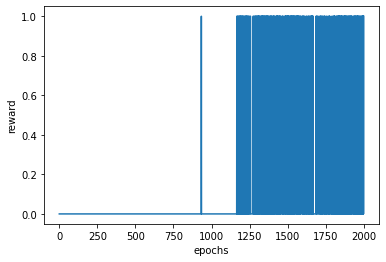

In [15]:
plt.plot(Reward)
plt.xlabel('epochs')
plt.ylabel('reward')

In [20]:
sac_test(env, sac, num_test=1, display=True)


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 1.182
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -1.887
 q1(s,S) = -0.243
 q1(s,R) = -1.653
 q1(s,N) = -1.165
 q2(s,L) = -1.887
 q2(s,S) = -0.243
 q2(s,R) = -1.653
 q2(s,N) = -1.165
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 1.351
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -6.221
 q1(s,S) = -0.977
 q1(s,R) = -1.014
 q1(s,N) = 0.608
 q2(s,L) = -6.221
 q2(s,S) = -0.977
 q2(s,R) = -1.014
 q2(s,N) = 0.608
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -1.842
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -4.010
 q1(s,S) = -1.484
 q1(s,R) = 0.969
 q1(s,N) = 0.045
 q2(s,L) = -4.010
 q2(s,S) = -1.484
 q2(s,R) = 0.969
 q2(s,N) = 0.045
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 

 q1(s,L) = -3.234
 q1(s,S) = -0.336
 q1(s,R) = -0.669
 q1(s,N) = 0.224
 q2(s,L) = -3.234
 q2(s,S) = -0.336
 q2(s,R) = -0.669
 q2(s,N) = 0.224
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -0.886
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -2.769
 q1(s,S) = -1.090
 q1(s,R) = -1.083
 q1(s,N) = -0.850
 q2(s,L) = -2.769
 q2(s,S) = -1.090
 q2(s,R) = -1.083
 q2(s,N) = -0.850
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -0.886
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -2.769
 q1(s,S) = -1.090
 q1(s,R) = -1.083
 q1(s,N) = -0.850
 q2(s,L) = -2.769
 q2(s,S) = -1.090
 q2(s,R) = -1.083
 q2(s,N) = -0.850
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -0.272
 pi(L|s) = 0.000
 pi(S|s) = 1.000
 pi(R|s) = 0.000
 pi(N|s) = 0.000
 q1(s,L) = -3.234
 q1(s,S) = -0.336
 q1(s,R) = -0.669
 q1(s,N) = 0.224
 q2(s

 q2(s,L) = -3.401
 q2(s,S) = -0.359
 q2(s,R) = -0.553
 q2(s,N) = -0.630
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -0.487
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -3.401
 q1(s,S) = -0.359
 q1(s,R) = -0.268
 q1(s,N) = 0.467
 q2(s,L) = -3.401
 q2(s,S) = -0.359
 q2(s,R) = -0.268
 q2(s,N) = 0.467
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -0.487
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -3.401
 q1(s,S) = -0.359
 q1(s,R) = -0.268
 q1(s,N) = 0.467
 q2(s,L) = -3.401
 q2(s,S) = -0.359
 q2(s,R) = -0.268
 q2(s,N) = 0.467
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 0.720
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -3.401
 q1(s,S) = -0.359
 q1(s,R) = 1.328
 q1(s,N) = -0.630
 q2(s,L) = -3.401
 q2(s,S) = -0.359
 q2(s,R) = 1.328
 q2(s,N) = -0.630
  (Right

 v(s) = 0.405
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -3.401
 q1(s,S) = -0.359
 q1(s,R) = -0.553
 q1(s,N) = -0.630
 q2(s,L) = -3.401
 q2(s,S) = -0.359
 q2(s,R) = -0.553
 q2(s,N) = -0.630
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -0.487
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -3.401
 q1(s,S) = -0.359
 q1(s,R) = -0.268
 q1(s,N) = 0.467
 q2(s,L) = -3.401
 q2(s,S) = -0.359
 q2(s,R) = -0.268
 q2(s,N) = 0.467
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 0.405
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -3.401
 q1(s,S) = -0.359
 q1(s,R) = -0.553
 q1(s,N) = -0.630
 q2(s,L) = -3.401
 q2(s,S) = -0.359
 q2(s,R) = -0.553
 q2(s,N) = -0.630
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -0.663
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 

INFO:TrainMonitor:ep: 2005, T: 135,493, G: 1, avg_G: 0.337, t: 119, dt: 7.307ms, loss: 1.51, policy/entropy: 6.32e-05, policy/loss: -0.0429, v_func/loss: 0.391, q_func1/loss: 0.386, q_func2/loss: 0.386, value/loss: 0.388


 v(s) = 0.405
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -3.401
 q1(s,S) = -0.359
 q1(s,R) = -0.553
 q1(s,N) = -0.630
 q2(s,L) = -3.401
 q2(s,S) = -0.359
 q2(s,R) = -0.553
 q2(s,N) = -0.630
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -0.487
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -3.401
 q1(s,S) = -0.359
 q1(s,R) = -0.268
 q1(s,N) = 0.467
 q2(s,L) = -3.401
 q2(s,S) = -0.359
 q2(s,R) = -0.268
 q2(s,N) = 0.467
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 0.720
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -3.401
 q1(s,S) = -0.359
 q1(s,R) = 1.328
 q1(s,N) = -0.630
 q2(s,L) = -3.401
 q2(s,S) = -0.359
 q2(s,R) = 1.328
 q2(s,N) = -0.630
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -0.487
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.

1.0

## 3) On-policy methods

### 3.1) REINFORCE (Iury)

### 3.2) PPO (Arthur)

## 4) Discussion